In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!kaggle datasets download -d elikplim/eergy-efficiency-dataset

Dataset URL: https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset
License(s): CC0-1.0
eergy-efficiency-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
file_name = '/content/eergy-efficiency-dataset.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('file extracted')

file extracted


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [12]:
data = pd.read_csv('/content/ENB2012_data.csv')

In [13]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [19]:
# Rename columns based on their real names
data.columns = [
    "Relative Compactness",   # X1
    "Surface Area",           # X2
    "Wall Area",              # X3
    "Roof Area",              # X4
    "Overall Height",         # X5
    "Orientation",            # X6
    "Glazing Area",           # X7
    "Glazing Area Distribution",  # X8
    "Heating Load",           # Y1
    "Cooling Load"            # Y2
]

# Verify the updated column names
print(data.head())


   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                          0         15.55   
1            3           0.0                          0         15.55   
2            4           0.0                          0         15.55   
3            5           0.0                          0         15.55   
4            2           0.0                          0         20.84   

   Cooling Load  
0         21.33  
1         21.33  
2         21.33  
3         21.3

In [20]:
data.columns

Index(['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
       'Overall Height', 'Orientation', 'Glazing Area',
       'Glazing Area Distribution', 'Heating Load', 'Cooling Load'],
      dtype='object')

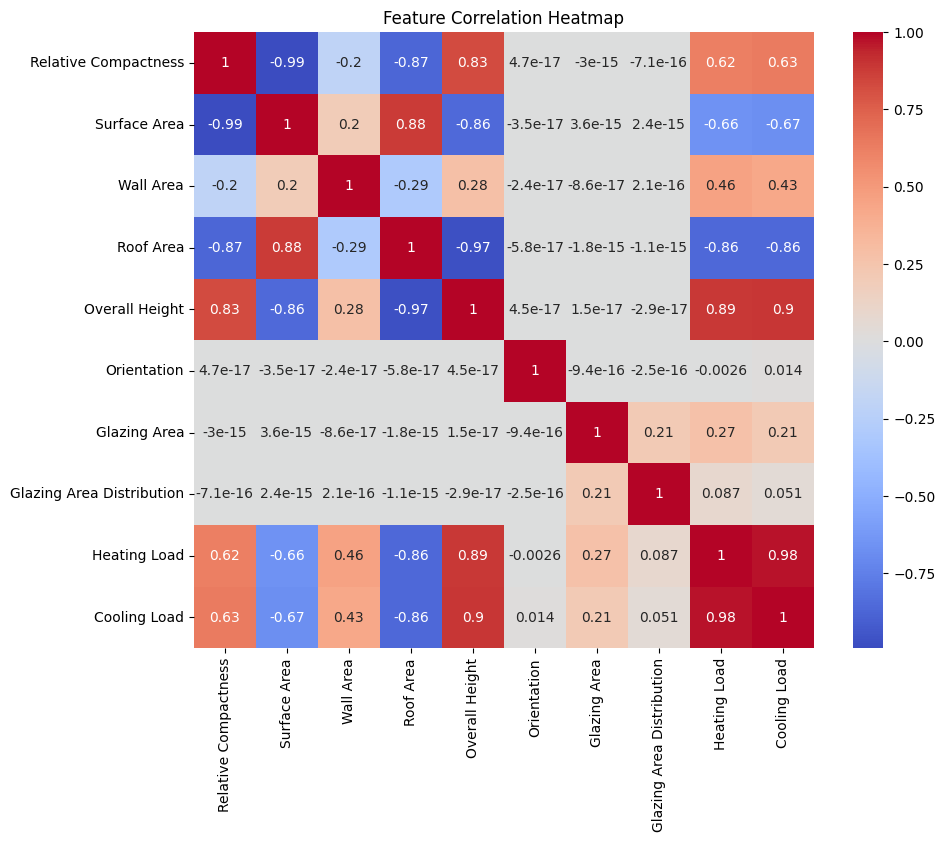

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


In [23]:
data.isnull().sum()

,0
Relative Compactness,0
Surface Area,0
Wall Area,0
Roof Area,0
Overall Height,0
Orientation,0
Glazing Area,0
Glazing Area Distribution,0
Heating Load,0
Cooling Load,0


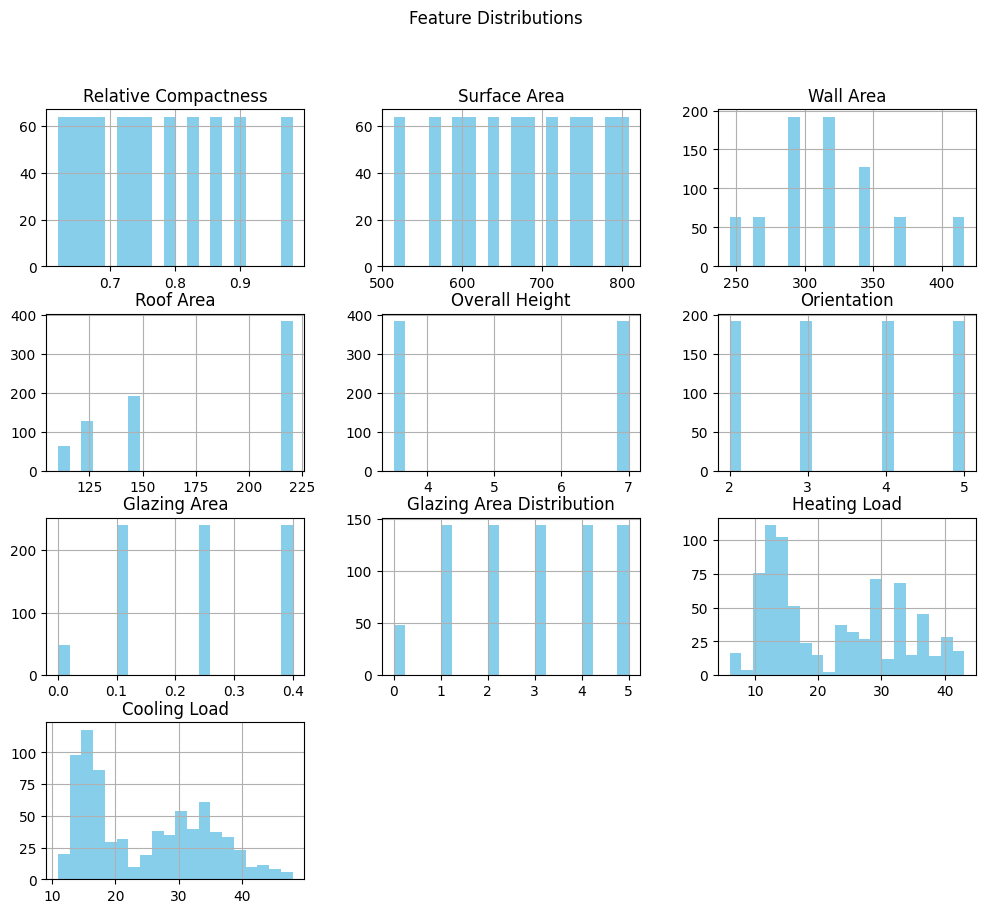

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

data.hist(figsize=(12, 10), bins=20, color='skyblue')
plt.suptitle("Feature Distributions")
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, :-2]  # All features except the last two columns
y_heating = data['Heating Load']  # Heating Load
y_cooling = data['Cooling Load']  # Cooling Load
X_train, X_test, y_train, y_test = train_test_split(X, y_heating, test_size=0.3, random_state=42)

In [26]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 0.3804182560019076
R² Score: 0.9985727555590409


In [28]:
import plotly.express as px

fig = px.scatter(x=y_test, y=predictions, labels={'x': 'Actual Values', 'y': 'Predicted Values'},
                 title="Actual vs Predicted Heating Load")
fig.add_shape(type="line", line_color="red", x0=min(y_test), y0=min(y_test),
              x1=max(y_test), y1=max(y_test))
fig.show()


<Figure size 1000x600 with 0 Axes>

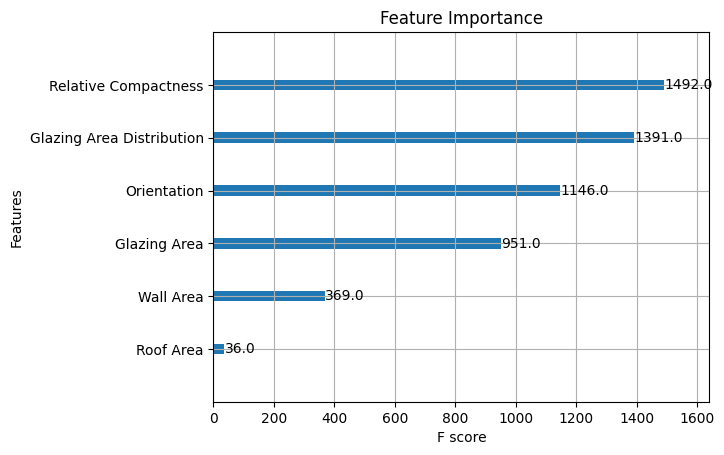

In [29]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='weight', title="Feature Importance", max_num_features=10)
plt.show()


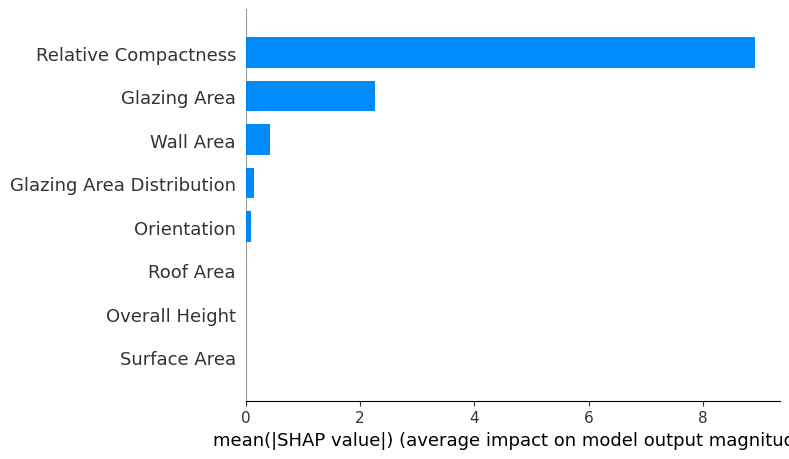

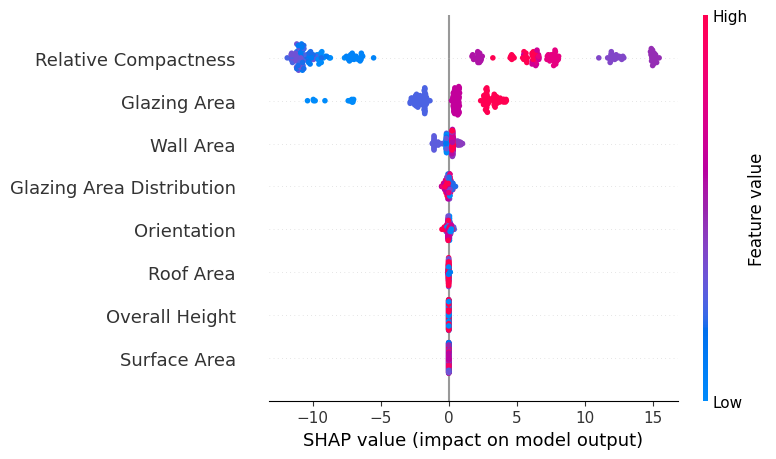

In [30]:
import shap

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


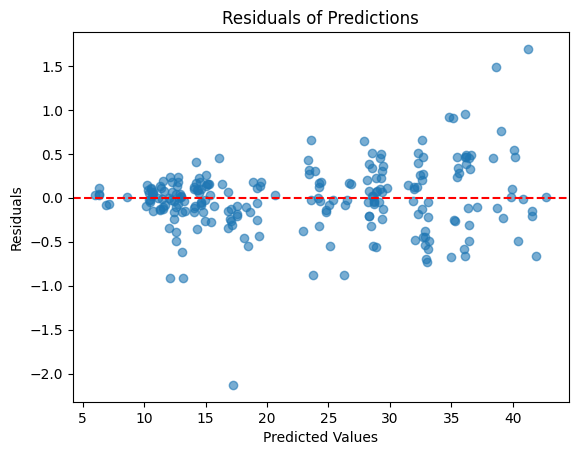

In [31]:
residuals = y_test - predictions
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals of Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


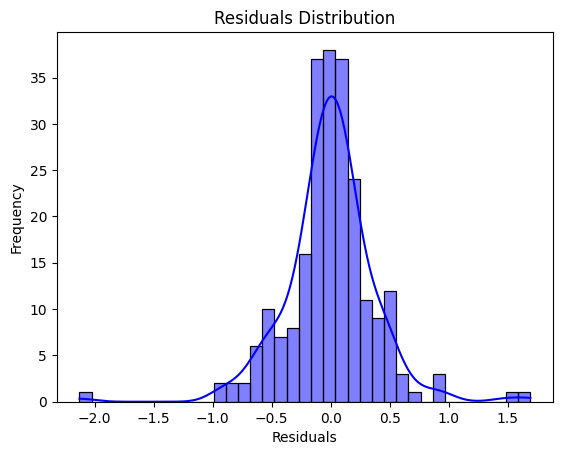

In [32]:
sns.histplot(residuals, kde=True, color="blue")
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [33]:
# Heating Load Model
model_heating = XGBRegressor()
model_heating.fit(X_train, y_train)

# Cooling Load Model
y_train_cooling = data['Cooling Load'][X_train.index]
model_cooling = XGBRegressor()
model_cooling.fit(X_train, y_train_cooling)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
def predict_loads(input_features):
    heating_pred = model_heating.predict([input_features])
    cooling_pred = model_cooling.predict([input_features])
    return heating_pred[0], cooling_pred[0]


In [39]:
import joblib

# Save the model
joblib.dump(model, 'Energy-efficiency.pkl')
joblib.dump(model_heating, 'heating_model.pkl')
joblib.dump(model_cooling, 'cooling_model.pkl')


['cooling_model.pkl']